In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt
from math import sqrt
from scipy.optimize import minimize
from skopt import gp_minimize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
pd.options.mode.chained_assignment = None

In [2]:
rf_df= pd.read_csv('/Users/vibhu_goel/Documents/Thesis/data/rf_prediction.csv')
rf_df.set_index('date',inplace=True)
rf_df.columns= ['rf_'+col if col not in ['split','actual'] else col for col in rf_df.columns]
del rf_df['split']
arima_df= pd.read_csv('/Users/vibhu_goel/Documents/Thesis/data/arima_prediction.csv')
arima_df.set_index('date',inplace=True)
arima_df.columns= ['sarima_'+col if col not in ['split','actual'] else col for col in arima_df.columns]

In [3]:
arima_df.shape

(350, 5)

In [4]:
arima_df.head(3)

,actual,sarima_predictions,sarima_lower_limit,sarima_upper_limit,split
date,,,,,
2016-01-01,1274.225161,0.000000,-0.999996,248398.746180,train
2016-01-02,1348.993491,1267.996596,800.389998,2008.449039,train
2016-01-03,1239.120974,1322.385883,851.134194,2054.251633,train


In [5]:
df= pd.merge(arima_df,rf_df,left_index=True,right_index=True,how='inner')
df.shape

(329, 6)

In [6]:
df[7:].head(3)

,actual,sarima_predictions,sarima_lower_limit,sarima_upper_limit,split,rf_predictions
date,,,,,,
2016-01-29,1121.633927,1081.957208,721.127714,1623.084343,train,1044.571362
2016-01-30,1015.839110,1125.746191,750.745226,1687.812825,train,1042.249433
2016-01-31,1076.144394,1077.556734,718.608444,1615.552221,train,1018.006057


In [19]:
X= df[df['split'] == 'train'][:]
# X= df[df['split'] == 'test']
print (X.shape)

(308, 7)


In [20]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
# Define a function to calculate RMSE for a given weight combination
def calculate_rmse(weights):
    combined_predictions = (weights[0] * X['sarima_predictions'] +
                           weights[1] * X['rf_predictions'])
    return np.sqrt(mean_squared_error(X['actual'], combined_predictions))

def calculate_mape(weights):
    combined_predictions = (weights[0] * X['sarima_predictions'] +
                           weights[1] * X['rf_predictions'])
    return mean_absolute_percentage_error(X['actual'], combined_predictions)

# Performing Time Series Cross-Validation to find the optimal weight for combining the predictions from your Time Series Model (ARIMA) and Machine Learning Model (Random Forest Regressor)

In [23]:
# Define the optimization objective function to minimize RMSE

def objective(weights,metric='mape'):
    if metric == 'mape':
        return calculate_mape(weights)
    if metric == 'rmse':
        return calculate_rmse(weights)

# Initial guess for the weights (e.g., 0.5 for each model)
initial_weights = [0.5, 0.5]

# Constraints for weights (sum of weights equals 1)
constraints = (
    {'type': 'eq', 'fun': lambda w: 1.0 - sum(w)}
)

# Bounds for the weights (between 0 and 1)
bounds = [(0, 1), (0, 1)]

# Minimize the RMSE by adjusting the weights
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal weights
optimal_weights = result.x

# Calculate the optimal combined predictions
optimal_combined_predictions = (optimal_weights[0] * X['sarima_predictions'] +
                                 optimal_weights[1] * X['rf_predictions'])

# Print the optimal weights and RMSE
print("Optimal Weights:", optimal_weights)
print("Optimal metric:", calculate_rmse(optimal_weights))

# You can use optimal_combined_predictions for forecasting
print("Optimal Combined Predictions:")
print(optimal_combined_predictions)


Optimal Weights: [4.93451863e-06 9.99995065e-01]
Optimal metric: 144.35775705399368
Optimal Combined Predictions:
date
2016-01-22    1233.558633
2016-01-23    1251.598805
2016-01-24    1072.682930
2016-01-25    1043.826057
2016-01-26    1076.437933
                 ...     
2016-11-20     823.408768
2016-11-21    1006.516037
2016-11-22     981.167188
2016-11-23     923.219900
2016-11-24     954.791122
Length: 308, dtype: float64


#  Bayesian optimization to find the optimal weightage for combining predictions from two models

In [24]:
# Sample data (replace this with your actual data)
actual_values = X['actual']
time_series_predictions = X['sarima_predictions']
ml_predictions = X['rf_predictions']

def objective(weights,metric='mape'):
    if metric == 'mape':
        return calculate_mape(weights)
    if metric == 'rmse':
        return calculate_rmse(weights)

# Define the optimization space (weights between 0 and 1)
space = [(0.0, 1.0), (0.0, 1.0)]

# Perform Bayesian optimization
result = gp_minimize(objective, space, n_calls=100, random_state=0)

# Extract the optimal weights
optimal_weights = result.x

# Calculate the optimal combined predictions
optimal_combined_predictions = optimal_weights[0] * time_series_predictions + optimal_weights[1] * ml_predictions

# Print the optimal weights and RMSE
print("Optimal Weights:", optimal_weights)
print("Optimal metric:", result.fun)

# You can use optimal_combined_predictions for forecasting
print("Optimal Combined Predictions:")
print(optimal_combined_predictions)


Optimal Weights: [1.842630386528384e-18, 0.9714267338716089]
Optimal metric: 12.51896880428954
Optimal Combined Predictions:
date
2016-01-22    1198.311856
2016-01-23    1215.836887
2016-01-24    1042.031708
2016-01-25    1013.999827
2016-01-26    1045.680012
                 ...     
2016-11-20     799.881343
2016-11-21     977.756888
2016-11-22     953.132185
2016-11-23     896.840061
2016-11-24     927.509786
Length: 308, dtype: float64


# Final Model Performance

In [27]:
# weight= [0.17748396, 0.82251604]
# weight= [0.1692702088392465, 0.8672633880063295]
##Final
weight= [0.21, 0.79]

df['weighted_prediction']= (df['sarima_predictions']*weight[0] + df['rf_predictions']*weight[1])

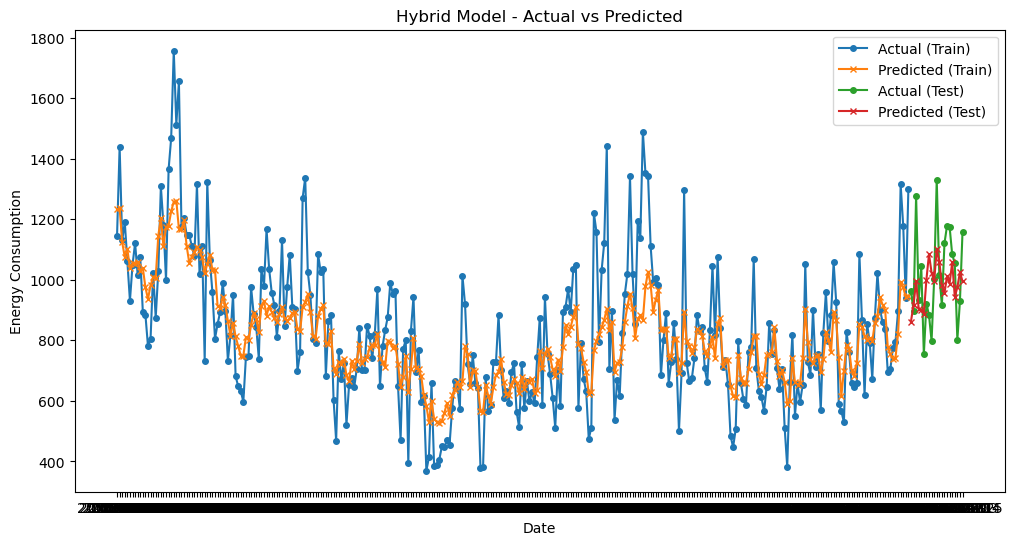

   split        RMSE  R-squared         MAE       MAPE
1  Train  143.072346   0.700229  104.487519  12.935870
0   Test  147.337968   0.103863  126.167613  12.487079


In [28]:
tmp= df[:]
# Calculate metrics and create a summary table
summary = tmp.groupby('split').apply(lambda x: pd.Series({
    'RMSE': np.sqrt(mean_squared_error(x['actual'], x['weighted_prediction'])),
    'R-squared': np.corrcoef(x['actual'], x['weighted_prediction'])[0, 1] ** 2,
    'MAE': mean_absolute_error(x['actual'], x['weighted_prediction']),
    'MAPE': np.mean(np.abs((x['actual'] - x['weighted_prediction']) / x['actual'])) * 100
})).reset_index().loc[::-1].replace({'test':'Test','train':'Train'})

train= tmp[tmp['split'] == 'train']
test= tmp[tmp['split'] == 'test']

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['actual'], label='Actual (Train)', marker='o', markersize=4)
plt.plot(train.index, train['weighted_prediction'], label='Predicted (Train)', marker='x', markersize=4)
plt.plot(test.index, test['actual'], label='Actual (Test)', marker='o', markersize=4)
plt.plot(test.index, test['weighted_prediction'], label='Predicted (Test)', marker='x', markersize=4)

plt.title('Hybrid Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

print(summary)


In [33]:
summary.T.to_dict()

{1: {'split': 'Train',
  'RMSE': 143.07234572670063,
  'R-squared': 0.7002290020242032,
  'MAE': 104.48751853183566,
  'MAPE': 12.935869686320467},
 0: {'split': 'Test',
  'RMSE': 147.33796775944623,
  'R-squared': 0.10386266514744887,
  'MAE': 126.16761320683602,
  'MAPE': 12.48707907412271}}

In [ ]:
# hybrid model:  {'Train': {
#   'RMSE': 143.07234572670063,
#   'R-squared': 0.7002290020242032,
#   'MAE': 104.48751853183566,
#   'MAPE': 12.935869686320467},
#  'Test': {
#   'RMSE': 147.33796775944623,
#   'R-squared': 0.10386266514744887,
#   'MAE': 126.16761320683602,
#   'MAPE': 12.48707907412271}}

# random forest model: {'Train': {
#   'RMSE': 144.357833,
#   'R-squared': 0.702718,
#   'MAE': 103.484771,
#   'MAPE': 12.715677},
#  'Test': {
#   'RMSE': 156.788649,
#   'R-squared': 0.061052,
#   'MAE': 136.532707,
#   'MAPE': 13.639599}}

# SARIMA model: {'Train': {
#   'RMSE': 169.762772,
#   'R-squared': 0.551196,
#   'MAE': 129.462871,
#   'MAPE': 16.047363},
#  'Test': {
#   'RMSE': 148.900129,
#   'R-squared':0.105045 ,
#   'MAE': 124.491617,
#   'MAPE': 12.037340}}